In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
from torchvision.models.segmentation import deeplabv3_resnet50
import torch
import torch.functional as F
import numpy as np
import requests
import cv2
import torchvision
from PIL import Image
try:
    from pytorch_grad_cam import GradCAM
except:
    !pip install grad-cam
    from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image

# A model wrapper that gets a resnet model and returns the features before the fully connected layer.
class ResnetFeatureExtractor(torch.nn.Module):
    def __init__(self, model):
        super(ResnetFeatureExtractor, self).__init__()
        self.model = model
        self.feature_extractor = torch.nn.Sequential(*list(self.model.children())[:-1])
                
    def __call__(self, x):
        return self.feature_extractor(x)[:, :, 0, 0]
        
resnet = torchvision.models.resnet50(pretrained=True)
resnet.eval()
model = ResnetFeatureExtractor(resnet)
print(model)


def get_image_from_url(url):
    """A function that gets a URL of an image, 
    and returns a numpy image and a preprocessed
    torch tensor ready to pass to the model """

    img = np.array(Image.open(requests.get(url, stream=True).raw))
    img = cv2.resize(img, (512, 512))
    rgb_img_float = np.float32(img) / 255
    input_tensor = preprocess_image(rgb_img_float,
                                   mean=[0.485, 0.456, 0.406],
                                   std=[0.229, 0.224, 0.225])
    return img, rgb_img_float, input_tensor

ResnetFeatureExtractor(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequentia

In [2]:
car_img, car_img_float, car_tensor = get_image_from_url("https://www.wallpapersin4k.org/wp-content/uploads/2017/04/Foreign-Cars-Wallpapers-4.jpg")
cloud_img, cloud_img_float, cloud_tensor = get_image_from_url("https://th.bing.com/th/id/OIP.CmONj_pGCXg9Hq9-OxTD9gHaEo?pid=ImgDet&rs=1")
car_concept_features = model(car_tensor)[0, :]
cloud_concept_features = model(cloud_tensor)[0, :]

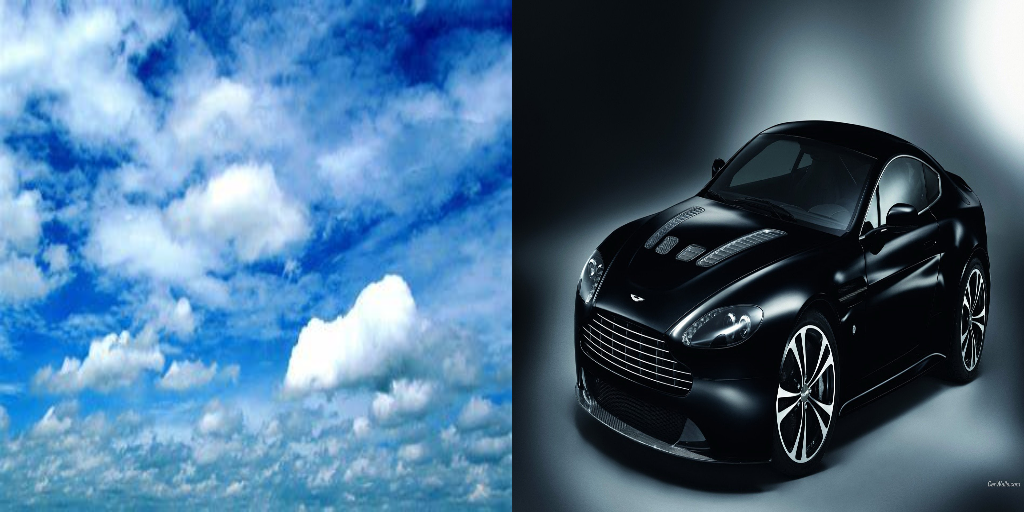

In [3]:
Image.fromarray(np.hstack((cloud_img, car_img)))

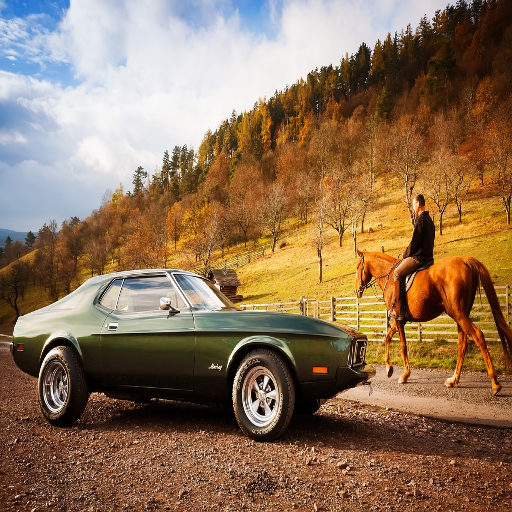

In [4]:
image, image_float, input_tensor = get_image_from_url("https://th.bing.com/th/id/R.c65135374de94dea2e2bf8fe0a4818e7?rik=Z75HF5uFr56PAw&pid=ImgRaw&r=0")
Image.fromarray(image)

[Bottleneck(
  (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
)]


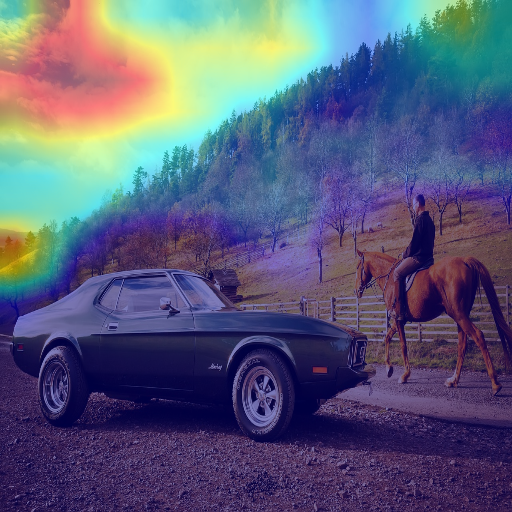

In [12]:
class SimilarityToConceptTarget:
    def __init__(self, features):
        self.features = features
    
    def __call__(self, model_output):
        cos = torch.nn.CosineSimilarity(dim=0)
        return cos(model_output, self.features)
    
    
from pytorch_grad_cam import GradCAMPlusPlus
target_layers = [resnet.layer4[-1]]
print(target_layers)

car_targets = [SimilarityToConceptTarget(car_concept_features), SimilarityToConceptTarget(cloud_concept_features)]
cloud_targets = [SimilarityToConceptTarget(cloud_concept_features)]

# Where is the car in the image
with GradCAM(model=model,
             target_layers=target_layers,
             use_cuda=False) as cam:
    car_grayscale_cam = cam(input_tensor=input_tensor,
                        targets=car_targets)[0, :]
car_cam_image = show_cam_on_image(image_float, car_grayscale_cam, use_rgb=True)
Image.fromarray(car_cam_image)

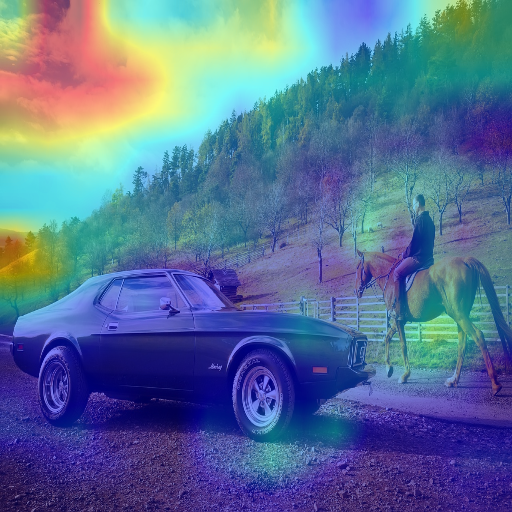

In [8]:
# Where is the cloud in the image
with GradCAMPlusPlus(model=model,
             target_layers=target_layers,
             use_cuda=False) as cam:
    cloud_grayscale_cam = cam(input_tensor=input_tensor,
                        targets=cloud_targets)[0, :]
cloud_cam_image = show_cam_on_image(image_float, cloud_grayscale_cam, use_rgb=True)
Image.fromarray(cloud_cam_image)

In [9]:
class DifferenceFromConceptTarget:
    def __init__(self, features):
        self.features = features
    
    def __call__(self, model_output):
        cos = torch.nn.CosineSimilarity(dim=0)
        return 1 - cos(model_output, self.features)

not_car_targets = [DifferenceFromConceptTarget(car_concept_features)]
not_cloud_targets = [DifferenceFromConceptTarget(cloud_concept_features)]

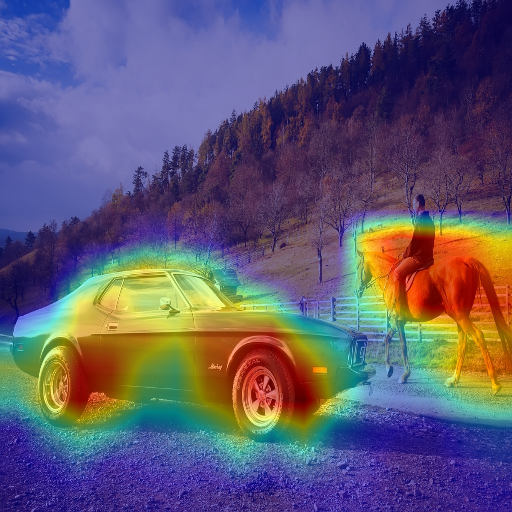

In [10]:
# Where is the cloud not in the image?
with GradCAM(model=model,
             target_layers=target_layers,
             use_cuda=False) as cam:
    not_cloud_grayscale_cam = cam(input_tensor=input_tensor,
                        targets=not_cloud_targets)[0, :]
cam_image = show_cam_on_image(image_float, not_cloud_grayscale_cam, use_rgb=True)
Image.fromarray(cam_image)

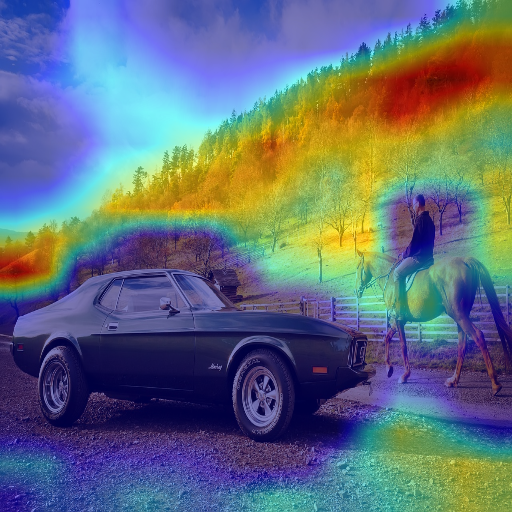

In [11]:
# Where is the car not in the image?
with GradCAM(model=model,
             target_layers=target_layers,
             use_cuda=False) as cam:
    not_car_grayscale_cam = cam(input_tensor=input_tensor,
                        targets=not_car_targets)[0, :]
cam_image = show_cam_on_image(image_float, not_car_grayscale_cam, use_rgb=True)
Image.fromarray(cam_image)

In [ ]:
Image.fromarray(np.hstack((cloud_img, car_img, image, car_cam_image, cloud_cam_image)))